***Import Modules***

In [1]:
import pandas as pd
import numpy as np
from pyts.decomposition import SSA
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from scipy import stats
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import itertools
import os
from sklearn.base import BaseEstimator

***Load in data for various companies***

In [2]:
#Companies: AAPL GOOG, FB, IBM, BB, MSFT, SAMSUNG
dataframes = [pd.read_csv('AAPL10YEAR.csv'), pd.read_csv('GOOG10YEAR.csv'), pd.read_csv('FB10YEAR.csv'), pd.read_csv('IBM10YEAR.csv'), pd.read_csv('BB10YEAR.csv'), pd.read_csv('MSFT10YEAR.csv'), pd.read_csv('SAMSUNG10YEAR.csv')]
data = [df.values for df in dataframes]


***Some visualization with SSA***

In [3]:
ssa = SSA(window_size = 50)
transformed = ssa.fit_transform(data[2].T[4].reshape((1, -1)))
transformed = transformed[0]

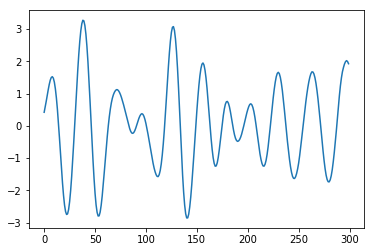

In [4]:
plt.plot(transformed[3][-300:]);

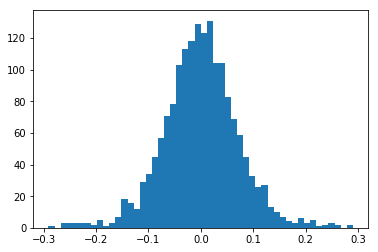

In [5]:
plt.hist(transformed[49], 50);

In [6]:
for i in range(5):
    print(np.std(transformed[i]))

52.545645715977734
2.5162809492807403
1.075143467301402
0.772023780025227
0.6760565178319204


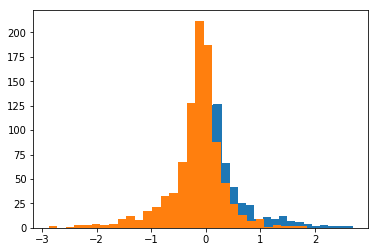

In [7]:
plt.hist([transformed[6][i] for i in range(90,transformed[1].size-7) if data[2].T[4][i] > data[2].T[4][i+7]], 30);
plt.hist([transformed[6][i] for i in range(90,transformed[1].size-7) if data[2].T[4][i] <= data[2].T[4][i+7]], 30);


***Approach: predict only one stock and use the SSA components as features***

In [8]:
ssa = SSA(window_size = 50)
closes = data[2].T[4]
transformed = ssa.transform(closes.reshape((1,-1)))[0]

In [9]:
labels = np.array(['down' if closes[i] > closes[i+7] else 'up' for i in range(transformed[1].size-7)])
input_data = transformed[:10].T[:-7]
train_xs, test_xs = input_data[:int(0.8*input_data.shape[0])], input_data[int(0.8*input_data.shape[0]):]
train_ys, test_ys = labels[:int(0.8*input_data.shape[0])], labels[int(0.8*input_data.shape[0]):]

In [10]:
up_number = labels[labels == 'up'].size
clf = GaussianNB(priors = [1 - up_number/labels.size, up_number/labels.size])
clf.fit(train_xs, train_ys)

GaussianNB(priors=[0.4309037900874636, 0.5690962099125364],
      var_smoothing=1e-09)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

down pred: 167 up pred: 176
down test: 157 up test: 186
Out of a total of 343 samples, 273 were correct
Normalized confusion matrix
[[0.8089172  0.1910828 ]
 [0.21505376 0.78494624]]


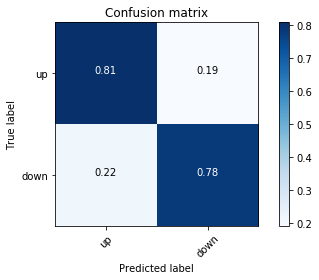

In [12]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print('down pred:', len([i for i in pred if i == 'down']), 'up pred:', len([i for i in pred if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))
cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

down pred: 147 up pred: 196
down test: 157 up test: 186
Out of a total of 343 samples, 283 were correct
Normalized confusion matrix
[[0.77707006 0.22292994]
 [0.1344086  0.8655914 ]]


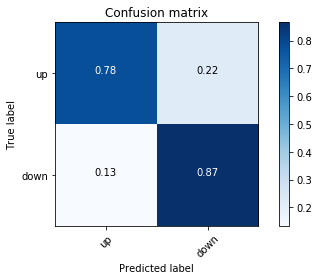

In [13]:
smote = SMOTE(random_state = 1729)
oversampled_xs, oversampled_ys = smote.fit_resample(train_xs, train_ys)
clf2 = svm.SVC(kernel = 'linear', probability = True, random_state = 42)
clf2.fit(oversampled_xs, oversampled_ys)
pred2 = clf2.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred2==test_ys if x==True])
print('down pred:', len([i for i in pred2 if i == 'down']), 'up pred:', len([i for i in pred2 if i == 'up']))
print('down test:', len([i for i in test_ys if i == 'down']), 'up test:', len([i for i in test_ys if i == 'up']))
print("Out of a total of %d samples, %d were correct" %(total, correct))
cnf_matrix = confusion_matrix(test_ys, pred2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['up', 'down'], normalize=True)

Average precision-recall score: 0.88


Text(0.5,1,'2-class Precision-Recall curve: AP=0.88')

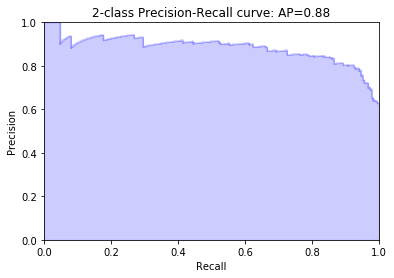

In [14]:
y_score = clf2.predict_proba(test_xs).T[1]
average_precision = average_precision_score(test_ys, y_score, pos_label = 'up')
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, thresholds = precision_recall_curve(test_ys, y_score, pos_label = 'up')
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

***Cross Validation and Statistical Significance Tests***

In [15]:
nb_scores = cross_val_score(clf, input_data, labels, cv = TimeSeriesSplit(n_splits = 20))
print("confidence interval: %f +/- %f" %(np.mean(nb_scores[10:]), (2/np.sqrt(10))*np.std(nb_scores[10:])))

confidence interval: 0.735802 +/- 0.053324


In [16]:
class oversample_svc(svm.SVC):
    """svc that oversamples train data before fitting"""
    def fit(self, X, y, sw = None):
        smote = SMOTE(random_state = 1729)
        oversampled_xs, oversampled_ys = smote.fit_resample(X, y)
        super().fit(oversampled_xs, oversampled_ys, sample_weight = sw)


oversample_clf2 = oversample_svc(kernel = 'linear', probability = True, random_state = 42)
svc_scores = cross_val_score(oversample_clf2, input_data, labels, cv = TimeSeriesSplit(n_splits = 20))
print("confidence interval: %f +/- %f" %(np.mean(svc_scores[10:]), (2/np.sqrt(10))*np.std(svc_scores[10:])))

confidence interval: 0.772840 +/- 0.030879


In [17]:
class trend_classifier(BaseEstimator):
    def fit(self, X, y, sw = None):
        pass
    
    def predict(self, X):
        return np.array(['up' if X[i-7] > X[i] else 'down' for i in range(X.size)])
    
    def score(self, X, y):
        predictions = self.predict(X)
        return (predictions == y).tolist().count(True) / y.size

trend_clf = trend_classifier()
trend_scores = cross_val_score(trend_clf, closes[:-7], labels, cv = TimeSeriesSplit(n_splits = 20))
print("confidence interval: %f +/- %f" %(np.mean(trend_scores[10:]), (2/np.sqrt(10))*np.std(trend_scores[10:])))

confidence interval: 0.556790 +/- 0.056677


In [18]:
nb_scores[10:]

array([0.69135802, 0.67901235, 0.81481481, 0.74074074, 0.74074074,
       0.75308642, 0.85185185, 0.5308642 , 0.7654321 , 0.79012346])

In [19]:
svc_scores[10:]

array([0.67901235, 0.7037037 , 0.79012346, 0.77777778, 0.7654321 ,
       0.74074074, 0.83950617, 0.81481481, 0.80246914, 0.81481481])

In [20]:
trend_scores[10:]

array([0.4691358 , 0.54320988, 0.59259259, 0.37037037, 0.59259259,
       0.60493827, 0.66666667, 0.48148148, 0.67901235, 0.56790123])

In [21]:
print(stats.ttest_rel(nb_scores[10:], trend_scores[10:]))
print(stats.ttest_rel(svc_scores[10:], trend_scores[10:]))
print(stats.ttest_rel(nb_scores[10:], svc_scores[10:]))

Ttest_relResult(statistic=6.355276633521202, pvalue=0.00013205004240685476)
Ttest_relResult(statistic=7.558065382861291, pvalue=3.4750993986607355e-05)
Ttest_relResult(statistic=-1.304484830218009, pvalue=0.22443816963333543)


***A function to make a prediction***

In [22]:
def predict_movement(classifier, past_values):
    """predicts the probability of upward movement over the next 7 days using the given classifier and historic values"""
    ssa = SSA(window_size = 50)
    transformed = ssa.fit_transform(past_values.reshape((1, -1)))[0][:10].T
    return (1 - classifier.predict_proba([transformed[-1]]).T[0])[0]

In [23]:
predict_movement(clf2, closes)

0.7290032630930052